In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os

directory = './LOSC_Event_tutorial/'

In [4]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #print(meta.items())
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#whitening: get rid of extra low-freq noise, noise around spectral lines
##transform to Fourier domain, divide by its noise amplitude spectrum
##resulting data has units of sigma from mean, instead of strain
def whiten(strain, ps, dt):
    n = len(strain)
    dfreq = 1.0/(n*dt)
    freq = np.arange(len(ps))*dfreq
    strainFT = np.fft.rfft(strain)
    whitenedFT = strainFT * (np.sqrt(1/ps))
    whitened = np.fft.irfft(whitenedFT)
    return whitened

#smoothing: akin to averaging between neighbouring frequency bins, resulting
##in a smoother spectrum
#In this case, convolving the data with a function (gaussian). This is 
## in hindsight not necessarily the best method, as it has the effect of 
##spreading out the sharp peaks, underweighting the good data in neighbouring
## bins and overweighting the data in the peaky bins. A better option might be
##some sort of tailored averaging, taking the median height amongst several bins
##instead of the mean.
    
def apply_smoothing_gaussian(data, fwhm):
    sigma = fwhm/(2.0*np.sqrt(2.0*np.log(2.0)))
    n = len(data)
    xvec = np.arange(n)
    xvec[n/2:]=xvec[n/2:] - n # why does this keep the FT real?
    smoother = np.exp(-0.5*xvec**2/sigma**2)
    smoother = smoother/smoother.sum()
    smootherFT = np.fft.rfft(smoother)
    dataFT = np.fft.rfft(data)
    convolveFT = dataFT * smootherFT
    smoothed_data = np.fft.irfft(convolveFT, n=n)
    return smoothed_data


Reading file H-H1_LOSC_4_V1-1167559920-32.hdf5


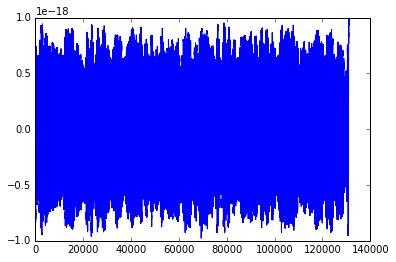

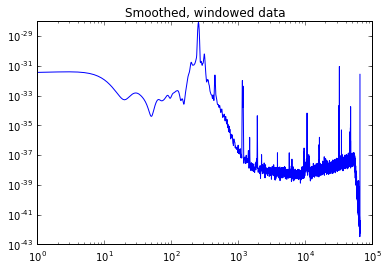

Reading file H-H1_LOSC_4_V2-1135136334-32.hdf5


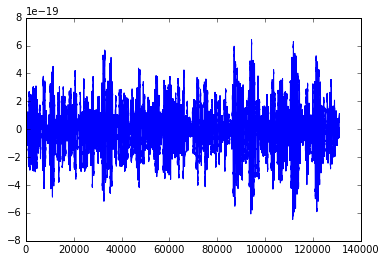

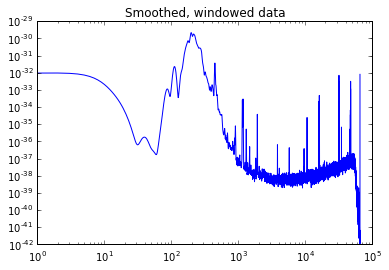

Reading file H-H1_LOSC_4_V2-1126259446-32.hdf5


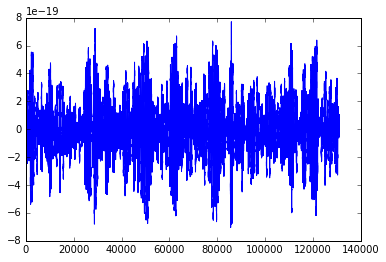

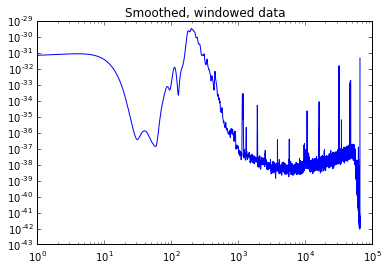

Reading file H-H1_LOSC_4_V2-1128678884-32.hdf5


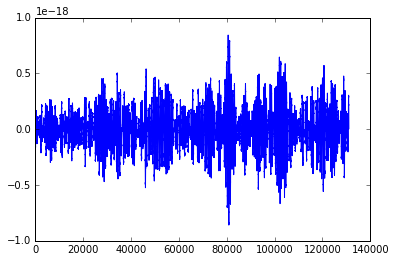

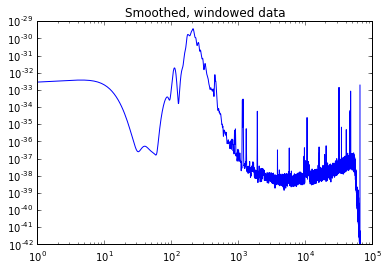

In [6]:
for filename in os.listdir(directory):
    
    if filename.startswith('H'): # hanford
        print('Reading file ' + filename)
        strain,dt,utc=read_file(directory + filename)
        
        #from LIGO: sample rate = 4096Hz
        fs = 4096
        plt.figure()
        plt.plot(strain)
        plt.title('Time-domain strain data')
        
        # first, window to avoid artifacts in the FT arising from discontinuities at edges
        # Choose a function that reaches the same point at each end of the domain, 
        ##and multiply the data by it. In this case, half a cosine, shifted up.
        x = np.linspace(-1.0, 1.0, len(strain))
        window_cos = 0.5 + 0.5*np.cos(np.pi*x)
        strainFT =np.fft.rfft(strain*window_cos)
#         plt.figure()
#         plt.loglog(strainFT)
#         plt.title('windowed amplitude spectrum')
        
        ps = np.abs(strainFT)**2 # power spectrum: strain^2/Hz --> strain/rtHz
#         plt.figure()
#         plt.loglog(ps)
#         plt.title('windowed power spectrum')

        #now smooth
        smoothed_ps = apply_smoothing_gaussian(ps, 10)
        plt.figure()
        plt.loglog(smoothed_ps)
        plt.title('Smoothed, windowed data')
        plt.show()
        
        dfreq = 1/(len(strain)*dt)
        freqs = dfreq * np.arange(len(smoothed_ps))
        
        # 'smoothed_ps' is the noise model for this dataset
                
# Then do this again for the Livingston data. I realized I still didn't
## understand what it means to combine the noise models for each event though.

## matched filter

$denom = \sqrt{AN^{-1}A}$

$RHS = FT(d)^*FT(A)/N^2$

$SNR = RHS/denom$

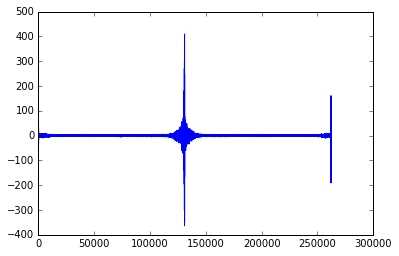

In [25]:
'''I tried this two different ways. This one is inspired by the LIGO tutorial.'''


# first, need a model (template) to search for:
#th,tl=read_template('GW150914_4_template.hdf5')
template_name='GW150914_4_template.hdf5'
#th,tl=read_template(directory + template_name)


whitened = whiten(strain*window_cos, smoothed_ps, dt)

temp = read_template(directory + template_name)
temp_r = temp[0]
temp_im = temp[1]

template = (temp_r + temp_im*1.j)

datafreq = np.fft.fftfreq(template.size)*fs

#use the FT match filter method because it's faster
tempFT = np.fft.fft(template)
dataFT = np.fft.fft(strain)

NFFT = fs*4
NOVL = NFFT/2
psd_window = np.blackman(NFFT)
psd, f = mlab.psd(strain, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
noise_vec = np.interp(np.abs(datafreq), f, psd)

rhs = np.fft.irfft(np.conj(dataFT)*tempFT / noise_vec)
denom = np.sqrt(np.dot(template, template/noise_vec))
snr = rhs/denom
plt.plot(snr)
plt.show()

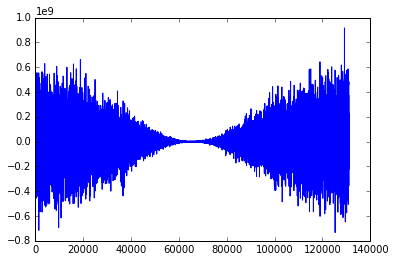

In [26]:
'''My second attempt, based on how we used matched filters in previous assignments
The two results look really different, but is that because in the above, we're using
a more optimized window type?
'''

#whiten the noise data and the template
whitened = whiten(strain*window_cos, smoothed_ps, dt)
tempFT = np.fft.rfft(whiten(temp_r*window_cos, smoothed_ps, dt))
dataFT = np.fft.rfft(whitened)

rhs = np.fft.irfft(np.conj(dataFT)*tempFT)
denom = np.sqrt(np.dot(temp_r, temp_r/whitened**2))
snr = rhs/denom
                
plt.plot(snr)
plt.show()

## halfway frequency

$<mm^T> = \sigma^2 = (A^T N^{-1} A)^{-1} = \dfrac{1}{\Sigma_i A_i^2/N_i}$ for $N$ diagonal (which it is, as we've rotated into Fourier space, and the noise is stationary). The weight on each datapoint in frequency space is given by $A^2_i/N_i$.

Find frequency $k$ such that $\Sigma_i A_i^2/N_i = 2\Sigma_{i}^{k} A_i/N_i$

In [27]:
# A is the template given for each event. N comes from all that processing in the first part.

total_weight = np.abs(np.sum(np.abs(temp)**2/whitened))

halfsum = 0.0
for i in range(len(temp_r)):
    halfsum = halfsum + np.abs(np.sqrt(temp_r[i]**2+temp_im[i]**2)**2/whitened[i])
    if halfsum >= total_weight/2.0:
        print(i)
        break
print('The frequency bin corresponding to halfway up the weights is ' + str(i) + ', corresponding to a frequency of: ' + str(i*dfreq))        

#what

1151
The frequency bin corresponding to halfway up the weights is 1151, corresponding to a frequency of: 35.96875


Does that frequency seem reasonable? Gosh does this not come naturally :P
Thanks for your help again!